# 1. Set Up

## 1.1 Import Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.tsa.stattools import adfuller

## 1.2 Load Dataset

In [2]:
# Load datasets
eur_nok = pd.read_csv('EUR to NOK Historical Exchage Rates.csv')
eur_sek = pd.read_csv('EUR to SEK Historical Exchage Rates.csv')
msci_energy = pd.read_csv('MSCI Europe Energy Historical Data.csv')
orkla = pd.read_csv('Orkla (ORK) Historical Data.csv')


### 1.2.1 Euro-NOK Exchange Rate

In [3]:
eur_nok.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,23/12/2022,10.4899,10.4633,10.5649,10.4275,NaN,0.38%
1,26/12/2022,10.4353,10.4838,10.5202,10.4470,NaN,-0.52%
2,27/12/2022,10.4349,10.4607,10.5151,10.4334,NaN,0.00%
3,28/12/2022,10.5012,10.4625,10.5137,10.4159,NaN,0.64%
4,29/12/2022,10.5253,10.5037,10.5629,10.4894,NaN,0.23%


### 1.2.2 Euro-SEK Exchange Rate

In [4]:
eur_sek.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,23/12/2022,11.1775,11.0958,11.1917,11.0467,NaN,0.80%
1,26/12/2022,11.1530,11.1727,11.2053,11.1314,NaN,-0.22%
2,27/12/2022,11.1362,11.1653,11.1875,11.1046,NaN,-0.15%
3,28/12/2022,11.1162,11.1469,11.1601,11.0579,NaN,-0.18%
4,29/12/2022,11.1459,11.1203,11.1688,11.1018,NaN,0.27%


### 1.2.3 MSCI Europe Energy Index

In [5]:
msci_energy.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,12/23/2022,156.29,155.37,156.37,154.87,NaN,0.48%
1,12/27/2022,156.28,156.36,157.38,156.26,NaN,-0.01%
2,12/28/2022,155.74,156.45,158.65,155.21,NaN,-0.35%
3,12/29/2022,155.62,154.92,156.19,153.89,NaN,-0.08%
4,12/30/2022,153.49,155.30,155.60,153.49,NaN,-1.37%


### 1.2.4 Orkla ASA Stock Price Oslo Stock Exchange

In [6]:
orkla.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,23/12/2022,70.44,70.26,70.84,70.12,748.90K,0.26%
1,27/12/2022,70.26,70.54,70.58,70.00,599.03K,-0.26%
2,28/12/2022,70.44,70.24,70.52,69.94,714.32K,0.26%
3,29/12/2022,71.08,70.24,71.08,69.72,691.85K,0.91%
4,30/12/2022,70.94,70.86,71.20,70.64,1.01M,-0.20%


## 1.3 Create a Single DataFrame

### 1.3.1 Convert MSCI dates

In [8]:
import pandas as pd

# Load the CSV file
df = msci_energy

# Attempt to parse with day-first assumption
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')

# Fill NaT values by trying an alternative format (MM/DD/YYYY)
df.loc[df['Date'].isna(), 'Date'] = pd.to_datetime(df.loc[df['Date'].isna(), 'Date'], format='%m/%d/%Y', errors='coerce')

# Convert to final desired format: DD/MM/YYYY
df['Date'] = df['Date'].dt.strftime('%d/%m/%Y')

msci_energy = df

# Display the updated dataframe
msci_energy.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,23/12/2022,156.29,155.37,156.37,154.87,NaN,0.48%
1,27/12/2022,156.28,156.36,157.38,156.26,NaN,-0.01%
2,28/12/2022,155.74,156.45,158.65,155.21,NaN,-0.35%
3,29/12/2022,155.62,154.92,156.19,153.89,NaN,-0.08%
4,30/12/2022,153.49,155.30,155.60,153.49,NaN,-1.37%


### 1.3.2 Join all 4 Datasets

In [9]:
# Convert date columns to datetime format and standardize
for df in [eur_nok, eur_sek, msci_energy, orkla]:
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Select relevant columns and rename for clarity
eur_nok = eur_nok[['Date', 'Price']].rename(columns={'Price': 'EUR/NOK'})
eur_sek = eur_sek[['Date', 'Price']].rename(columns={'Price': 'EUR/SEK'})
msci_energy = msci_energy[['Date', 'Price']].rename(columns={'Price': 'MSCI_Energy'})
orkla = orkla[['Date', 'Price']].rename(columns={'Price': 'ORK_Price'})

# Merge datasets on Date
merged_df = orkla.merge(eur_nok, on='Date', how='left') \
                 .merge(eur_sek, on='Date', how='left') \
                 .merge(msci_energy, on='Date', how='left')

# Sort data by date
merged_df = merged_df.sort_values(by='Date')
print(merged_df.head())

        Date  ORK_Price  EUR/NOK  EUR/SEK  MSCI_Energy
0 2022-12-23      70.44  10.4899  11.1775       156.29
1 2022-12-27      70.26  10.4349  11.1362       156.28
2 2022-12-28      70.44  10.5012  11.1162       155.74
3 2022-12-29      71.08  10.5253  11.1459       155.62
4 2022-12-30      70.94  10.4842  11.1384       153.49


## 1.4 Stationarity

### 1.4.1 Check for Stationarity

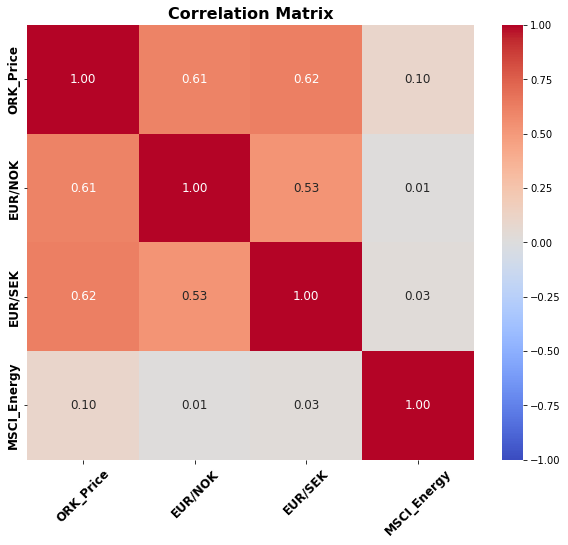

{'ORK_Price': 0.15910185829763152,
 'EUR/NOK': 0.09467511263449768,
 'EUR/SEK': 0.44632564293884086,
 'MSCI_Energy': 0.19148519909070827}

In [10]:


# Perform ADF test for stationarity
adf_results = {col: adfuller(merged_df[col].dropna())[1] for col in ['ORK_Price', 'EUR/NOK', 'EUR/SEK', 'MSCI_Energy']}

# Compute correlation matrix
correlation_matrix = merged_df[['ORK_Price', 'EUR/NOK', 'EUR/SEK', 'MSCI_Energy']].corr()


# Plot the enhanced correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True,
            vmin=-1, vmax=1, annot_kws={"size": 12})
plt.title("Correlation Matrix", fontsize=16, fontweight="bold")
plt.xticks(fontsize=12, rotation=45, fontweight="bold")
plt.yticks(fontsize=12, fontweight="bold")
plt.show()

adf_results

### 1.4.2 Make the Dataset Stationary

In [11]:
# Compute first percentage change to make the series stationary
diff_df = merged_df.copy()
diff_df[['ORK_Price', 'EUR/NOK', 'EUR/SEK', 'MSCI_Energy']] = diff_df[['ORK_Price', 'EUR/NOK', 'EUR/SEK', 'MSCI_Energy']].pct_change()

# Drop first row (NaN due to differencing)
diff_df = diff_df.dropna()

# Re-run ADF test on differenced data
adf_results_diff = {col: adfuller(diff_df[col])[1] for col in ['ORK_Price', 'EUR/NOK', 'EUR/SEK', 'MSCI_Energy']}

# Display the updated stationarity test results
adf_results_diff


{'ORK_Price': 1.4905689661568502e-29,
 'EUR/NOK': 5.433000982411408e-29,
 'EUR/SEK': 6.508610507184168e-29,
 'MSCI_Energy': 1.2671600382606434e-29}

### 1.4.3 Stationary Dataset Correlation Matrix

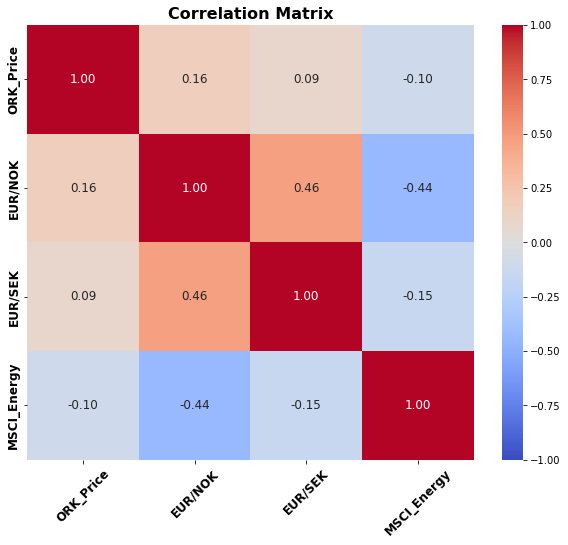

In [12]:
correlation_matrix = diff_df[['ORK_Price', 'EUR/NOK', 'EUR/SEK', 'MSCI_Energy']].corr()

# Plot the enhanced correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True,
            vmin=-1, vmax=1, annot_kws={"size": 12})
plt.title("Correlation Matrix", fontsize=16, fontweight="bold")
plt.xticks(fontsize=12, rotation=45, fontweight="bold")
plt.yticks(fontsize=12, fontweight="bold")
plt.show()


# 2. Variables Relationships

## 2.1 Train an XGBoost Model

In [13]:
"""
Predictors:
    - MSCI Energy Index
    - EUR/NOK Exchange Rate
    - EUR/SEK Exchange Rate

Predictions:
    - ORK Share Price
"""
# Split the dataset into the dependent and independent variables
X = diff_df[['EUR/NOK', 'EUR/SEK', 'MSCI_Energy']]
y = diff_df['ORK_Price']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Train XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train, y_train)

# Evaluate model
y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display training results
print(f'Mean Squared Error: {mse}')
print(f'R-Squared: {r2}')


Mean Squared Error: 0.0002472540688545071
R-Squared: -0.09349732847052206


## 2.2 Test the model

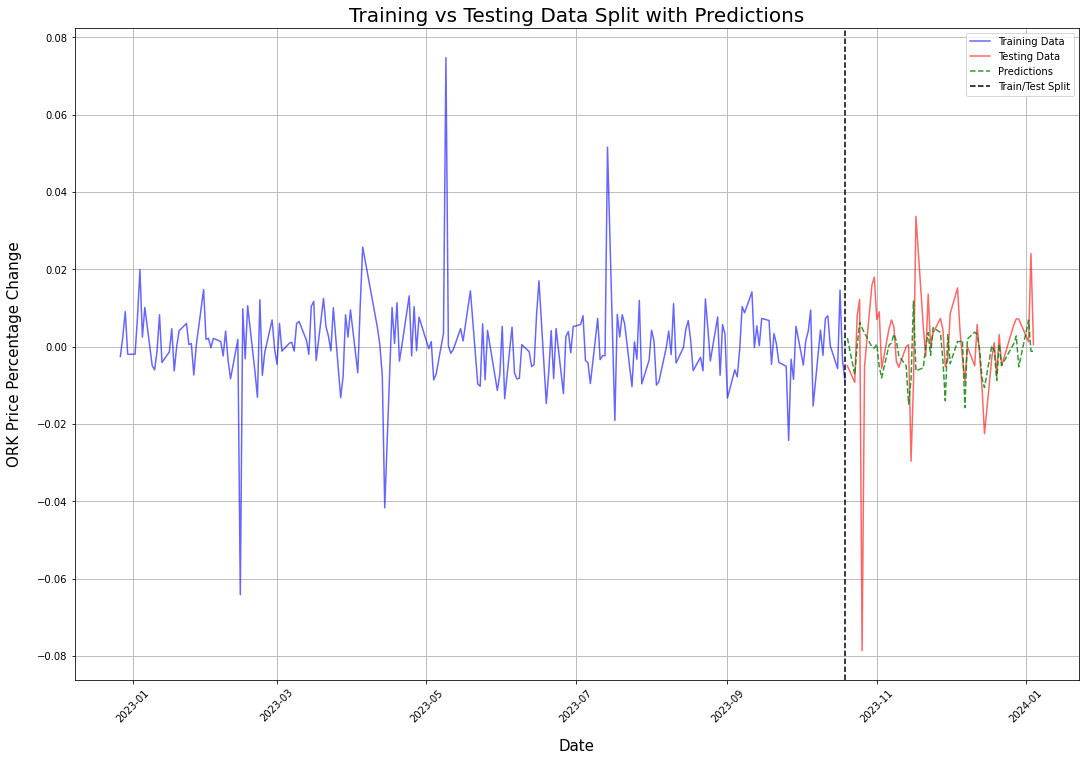

In [14]:
import matplotlib.pyplot as plt

# Ensure that X_train and X_test have their corresponding dates
X_train_dates = merged_df.loc[X_train.index, 'Date']
X_test_dates = merged_df.loc[X_test.index, 'Date']

plt.figure(figsize=(18, 12))

# Plot training data with corresponding dates
plt.plot(X_train_dates, y_train, label="Training Data", color="blue", alpha=0.6)

# Plot testing data with corresponding dates
plt.plot(X_test_dates, y_test, label="Testing Data", color="red", alpha=0.6)

# Plot predictions using the test dates
plt.plot(X_test_dates, y_pred, label="Predictions", color="green", linestyle="dashed", alpha=0.8)

# Mark the train-test split
plt.axvline(X_train_dates.iloc[-1], color="black", linestyle="dashed", label="Train/Test Split")

# Format the x-axis for better readability
plt.xticks(rotation=45)
plt.xlabel("Date", labelpad=15,size=15)
plt.ylabel("ORK Price Percentage Change", labelpad=15,size=15)
plt.title("Training vs Testing Data Split with Predictions", size=20)
plt.legend()
plt.grid()
plt.show()


# 3. Monte Carlo Simulation

## 3.1 Run the Monte Carlo Simulation

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Number of simulations and days
num_simulations = 1000
num_days = 11

# The Predictors can change by a random amount in range -5% to 10%
change_range = [-5,10]

# Store all simulated price paths
simulated_paths = np.zeros((num_simulations, num_days))

# Monte Carlo Simulation
for sim in range(num_simulations):
    # Start with the last known ORK_Price
    simulated_price = [y_test.iloc[-1]]  # Using last actual known price change as starting point

    for day in range(num_days):
        # Generate random changes for EUR/NOK, EUR/SEK, and MSCI_Energy
        random_features = np.random.uniform(change_range[0], change_range[1], size=(1, 3))
        
        # Predict ORK price change using the trained XGBoost model
        predicted_change = xgb_model.predict(random_features)[0]
        
        # Append the new price change
        simulated_price.append(simulated_price[-1] + predicted_change)
    
    # Store the simulated path
    simulated_paths[sim] = simulated_price[1:]  # Exclude initial




## 3.2 Display the Results

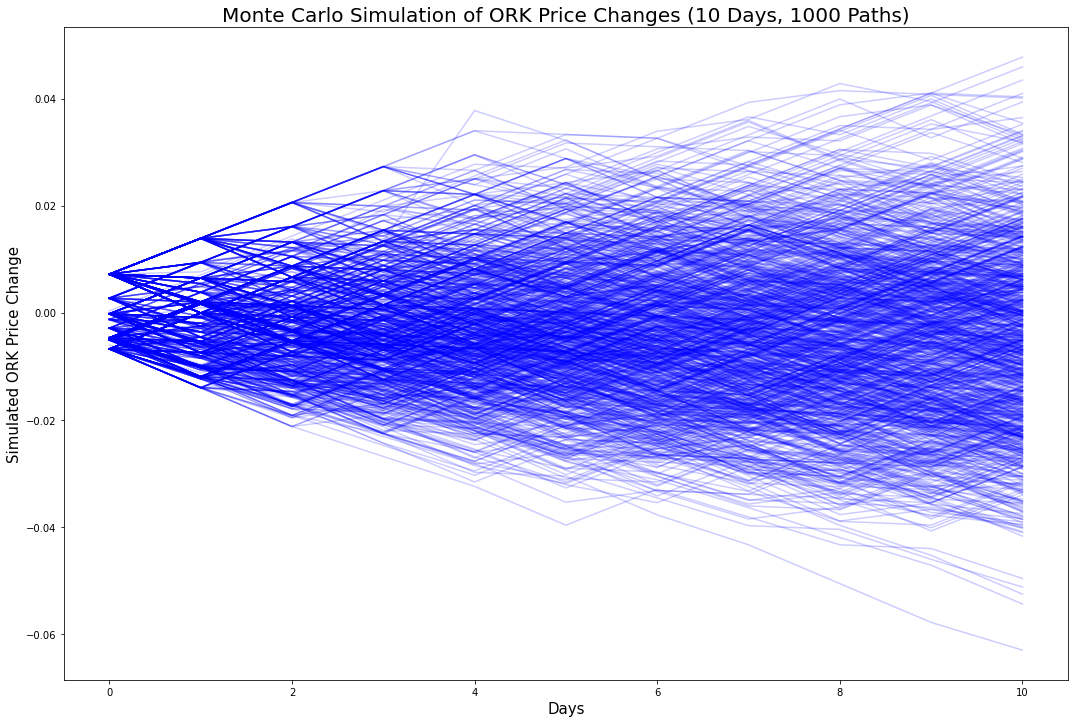

In [16]:
# Plot Monte Carlo Simulations
plt.figure(figsize=(18, 12))
for sim in range(num_simulations):
    plt.plot(simulated_paths[sim], alpha=0.2, color='blue')

plt.title("Monte Carlo Simulation of ORK Price Changes (10 Days, 1000 Paths)", size=20)
plt.xlabel("Days", size=15)
plt.ylabel("Simulated ORK Price Change", size=15)
plt.show()

# 4. Value at Risk

## 4.1 Calculate the 5% VaR for the 10-Day Returns

In [17]:


last_actual_price = merged_df['ORK_Price'].iloc[-1]

# Convert daily changes to final prices for each simulation
num_simulations, num_days = simulated_paths.shape
final_prices = np.zeros(num_simulations)

for i in range(num_simulations):
    total_change = np.sum(simulated_paths[i])
    final_prices[i] = last_actual_price + total_change

# Compute 10-day returns
ten_day_returns = (final_prices - last_actual_price) / last_actual_price

# Choose a confidence level for VaR
confidence_level = 0.95
alpha = 1 - confidence_level  # 0.05

# 5th percentile return
percentile_5_return = np.percentile(ten_day_returns, 100 * alpha)

# VaR as a positive loss percentage
VaR_95_pct = -percentile_5_return  # Flip sign if it's negative

# VaR in currency terms (if holding 1 share)
VaR_95_currency = last_actual_price * VaR_95_pct

print(f"5th percentile 10-day return at {confidence_level*100}% CL: {percentile_5_return:.4%}")
print(f"VaR 95% (as %): {VaR_95_pct:.4%}")
print(f"VaR 95% in price terms (1 share): {VaR_95_currency:.2f} NOK")


5th percentile 10-day return at 95.0% CL: -0.2653%
VaR 95% (as %): 0.2653%
VaR 95% in price terms (1 share): 0.21 NOK


## 4.2 Visualise the Results

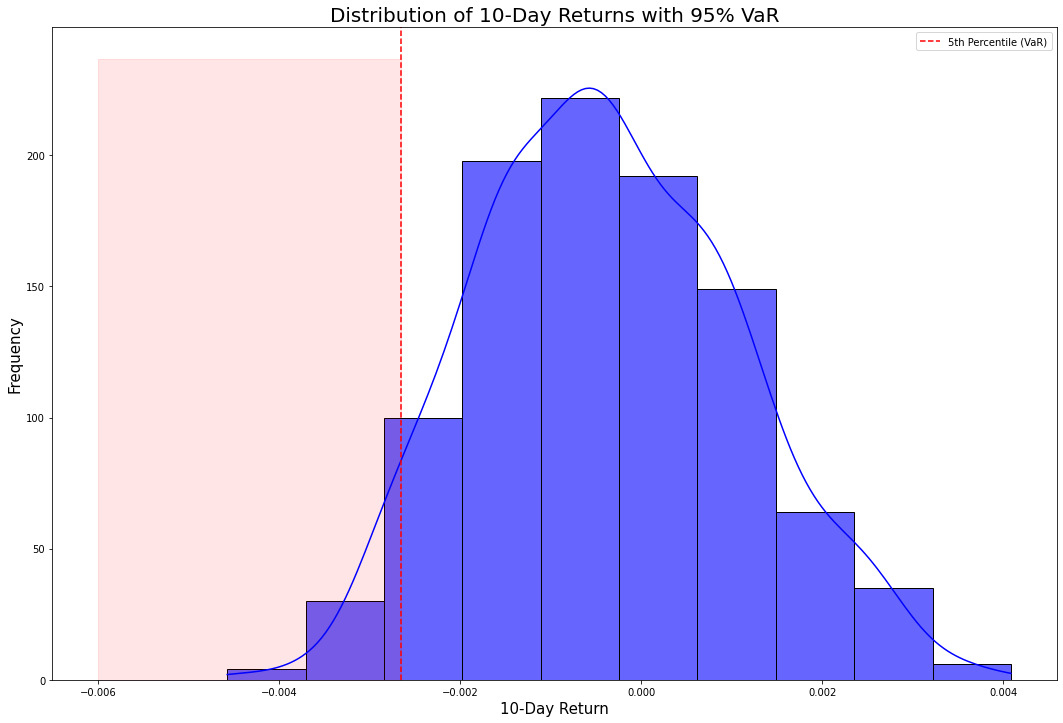

In [18]:
# Plot the distribution of returns
plt.figure(figsize=(18, 12))
sns.histplot(ten_day_returns, bins=10, kde=True, color='blue', alpha=0.6)

# Mark the VaR cutoff (5th percentile)
plt.axvline(x=percentile_5_return, color='red', linestyle='--', label='5th Percentile (VaR)')

# (Optional) Shade the area to the left of the VaR line to show the "worst 5%" zone
plt.fill_betweenx(
    y=[0, plt.gca().get_ylim()[1]], 
    x1=percentile_5_return, 
    x2=-0.006, 
    color='red', 
    alpha=0.1
)

# Add titles and labels
plt.title('Distribution of 10-Day Returns with 95% VaR', size=20)
plt.xlabel('10-Day Return', size=15)
plt.ylabel('Frequency', size=15)
plt.legend()

# Show the plot
plt.show()


# 5. References
- Brett Humphreys discusses the many decisions associated with a Monte Carlo value-at-risk calculation Valid assumptions required: Monte Carlo VaR


- Introductory Econometrics for Finance by Chris Brooks


- https://en.wikipedia.org/wiki/Value_at_risk


- https://www.investopedia.com/articles/04/092904.asp#:~:text=Value%20at%20Risk%20(VaR)%20is,size%20of%20the%20possible%20loss.